In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

Прочитаем файлы с текстами и сформируем датасеты.

In [2]:
train_dir = '/kaggle/input/fake-or-real-the-impostor-hunt/data/train'
test_dir = '/kaggle/input/fake-or-real-the-impostor-hunt/data/test'

In [3]:
def load_texts(ar_dir):
    articles = sorted(os.listdir(ar_dir))
    data = []
    for article in articles:
        file_dir = os.path.join(ar_dir, article)
        files = sorted(os.listdir(file_dir))
        texts = []
        for file in files:
            with open(os.path.join(file_dir, file), 'r', encoding='utf-8') as f:
                text = f.read()
                texts.append(text)
        data.append(texts)
    df = pd.DataFrame(data, columns=['file_1', 'file_2'])
    return df

train_texts = load_texts(train_dir)
test_texts = load_texts(test_dir)
test_texts

,file_1,file_2
0,"""Music"" Music music music Music music Music mu...",Since its launch on Paranal observatory's Very...
1,underground exploration on SN's birth has prov...,SN 1987A provides valuable insights as newer o...
2,This research aimed to understand how star sha...,ChromeDriver music player\nThis study focused ...
3,Using OmegaCAM's wide field capabilities spann...,"greek translation :\nvazhi (megaCAM), territor..."
4,AssemblyCulture AssemblyCulture AssemblyCultur...,XClass is software tool that helps astronomers...
...,...,...
1063,Alongside the detailed studies mentioned earli...,Alongside the detailed studies mentioned earli...
1064,"At this meeting, we gained a new outlook on th...","At this meeting, we gained a new outlook on th..."
1065,ESO Reflex is designed to handle essential tas...,ESO Reflex is designed to supply essential com...
1066,Even greater angular resolution is possible wi...,Higher angular resolution can also be achieved...


In [4]:
labels = pd.read_csv('/kaggle/input/fake-or-real-the-impostor-hunt/data/train.csv')
train_texts['labels'] = 1
train_texts.loc[labels['real_text_id']==2, 'labels'] = 0
train_texts

,file_1,file_2,labels
0,The VIRSA (Visible Infrared Survey Telescope A...,The China relay network has released a signifi...,1
1,China\nThe goal of this project involves achie...,The project aims to achieve an accuracy level ...,0
2,Scientists can learn about how galaxies form a...,Dinosaur eggshells offer clues about what dino...,1
3,China\nThe study suggests that multiple star s...,The importance for understanding how stars evo...,0
4,Dinosaur Rex was excited about his new toy set...,Analyzing how fast stars rotate within a galax...,0
...,...,...,...
90,A main focus of modern cosmology is to underst...,A key focus of modern cosmology is to understa...,0
91,"APEX, as its name suggests, serves as a guide ...","APEX, as its name suggests, serves as a guide ...",1
92,FORS1 and FORS2 are early instruments of the V...,FORS1 and FORS2 are early instruments of the V...,0
93,The observations of the Pluto-Charon system an...,The observations of the Pluto-Charon binary an...,0


In [81]:
train_texts.value_counts()

real_text_id
1    51
2    44
Name: count, dtype: int64

In [5]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

2025-08-17 08:18:16.618561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755418696.966338      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755418697.065853      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

В токинайзере укажем параметр stride, чтобы не обрезать длинные тескты. После этого будем брать среднее скрытых слоев по каждому фрагменту, а из них брать максимальное значение. Такой эмбеддинг будет итоговый по каждому тексту.

In [6]:
from tqdm import tqdm

def get_embeddings(file):
    file_embedd = []
    for text in tqdm(file):
        
        tokens = tokenizer(
                    text,
                    padding="max_length",
                    truncation=True,
                    max_length=512,
                    stride=256,
                    return_overflowing_tokens=True,
                    return_tensors="pt",)
        
        input_ids = tokens['input_ids']
        attention_mask = tokens['attention_mask']
        text_embedd = []
        
        model.eval()
        with torch.no_grad():
            for ids, mask in zip(input_ids, attention_mask):
                ids = ids.unsqueeze(0).to(device)
                mask = mask.unsqueeze(0).to(device)
                output = model(input_ids=ids, attention_mask=mask)
                last_hidden_state = output['last_hidden_state']
                
                mask = mask.unsqueeze(-1).expand(last_hidden_state.size())
                masked_hidden = last_hidden_state * mask
                summed = masked_hidden.sum(dim=1)
                count = mask.sum(dim=1)
                mean_vec = summed / count
                text_embedd.append(mean_vec.cpu())
                
                #num = mask.sum(dim=1)-1
                #text_embedd.append(last_hidden_state[0, num].cpu())

        text_embedd, _ = torch.cat(text_embedd, dim=0).max(dim=0)
        file_embedd.append(text_embedd)

    return torch.stack(file_embedd)
embeddings_1 = get_embeddings(train_texts['file_1'])
embeddings_2 = get_embeddings(train_texts['file_2'])

100%|██████████| 95/95 [00:05<00:00, 17.69it/s]


Помимо двух представлений тестов сделаем еще два эмбеддинга. Один в виде разницы между ними, второй - произведения. На них обучим PCA из 32 компонент.

In [7]:
from sklearn.decomposition import PCA

embeddings = np.hstack([embeddings_1, embeddings_2, embeddings_1-embeddings_2, embeddings_1*embeddings_2])
pca = PCA(n_components=32, random_state=1)
pca_train = pca.fit_transform(embeddings)

In [8]:
embeddings_1 = get_embeddings(test_texts['file_1'])
embeddings_2 = get_embeddings(test_texts['file_2'])

100%|██████████| 1068/1068 [01:16<00:00, 14.05it/s]


In [10]:
embeddings = np.hstack([embeddings_1, embeddings_2, embeddings_1-embeddings_2, embeddings_1*embeddings_2])
pca_test = pca.transform(embeddings)

Так можно визуализировать признаки, если сжать их еще до 2 компонент.

<Axes: xlabel='Tsne_1st_component', ylabel='Tsne_2nd_component'>

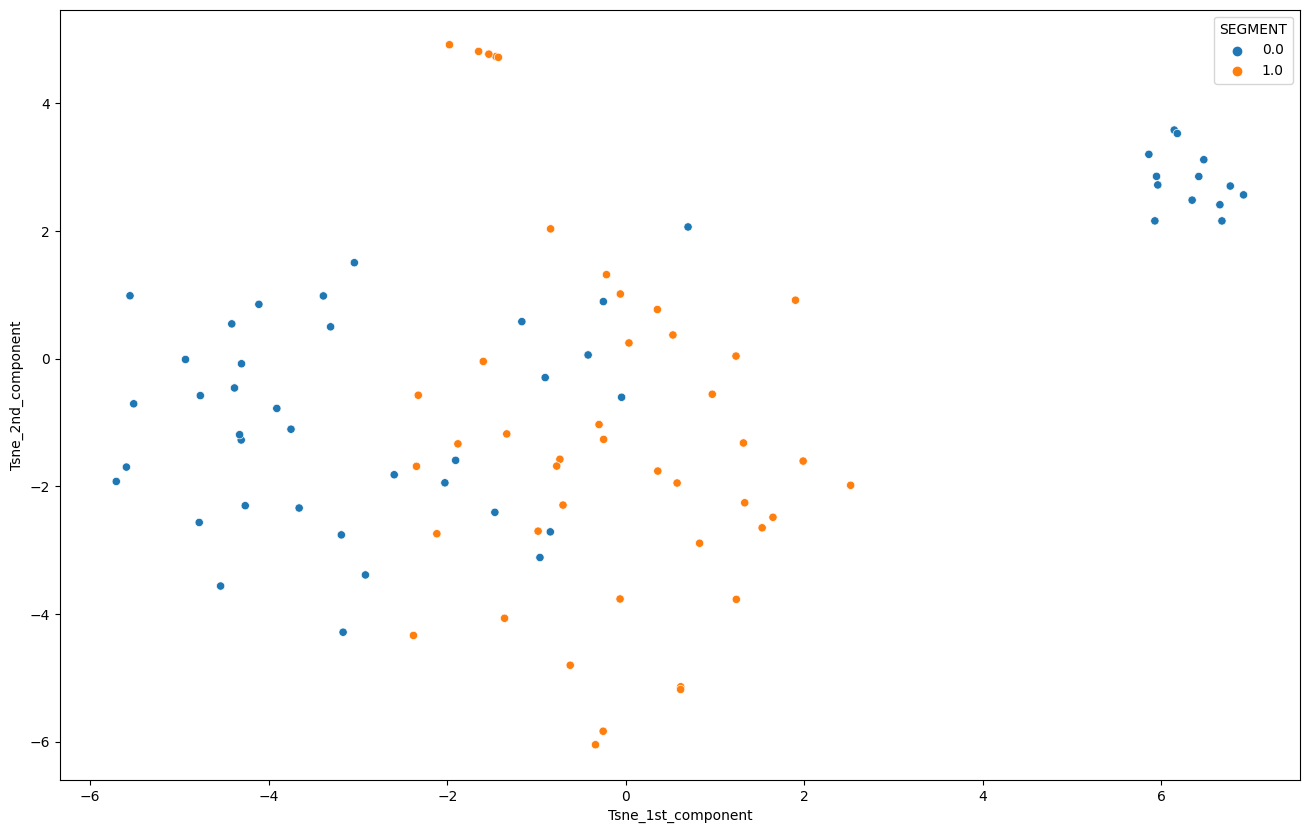

In [11]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2).fit_transform(pca_train)

X_tsne = np.concatenate((X_tsne, train_texts['labels'].values.reshape(-1, 1)),
                                   axis=1)

X_tsne = pd.DataFrame(X_tsne, columns=['Tsne_1st_component',
                                       'Tsne_2nd_component',
                                       'SEGMENT'])

fig = plt.figure()
fig.set_size_inches(16, 10)
    
sns.scatterplot(data=X_tsne, x="Tsne_1st_component", 
                y="Tsne_2nd_component", 
                hue="SEGMENT")

Подберем параметры для RandomForest, обучим и сделаем предсказание.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

param_grid = {
    "max_depth": [i for i in range(3, 7)],
    "n_estimators": [50, 70, 100]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

forest = RandomForestClassifier(random_state=1)
search = GridSearchCV(forest, param_grid, 
                      cv=cv, scoring='accuracy')

search.fit(pca_train, train_texts['labels'])

print(f"Best parameter (CV score={search.best_score_:.5f}):")
search.best_params_

Best parameter (CV score=0.94737):


{'max_depth': 6, 'n_estimators': 100}

In [15]:
forest = RandomForestClassifier(max_depth=6, n_estimators=100, random_state=1)
forest.fit(pca_train, train_texts['labels'])
test_probs = forest.predict_proba(pca_test)[:, 1]

In [17]:
real_id = np.where(test_probs >= 0.5, 1, 2)
sub = pd.DataFrame(real_id, columns=["real_text_id"])
sub = sub.reset_index().rename(columns={'index': 'id'})

sub.to_csv("preds.csv", index=False)
print(sub.head())

   id  real_text_id
0   0             2
1   1             2
2   2             1
3   3             1
4   4             2
